<a href="https://colab.research.google.com/github/KazukiHirata-sun/ai_project_dev_2022/blob/main/section_3/Improve_accuracy_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Improve the Accuracy of Our CNN
Eexperiment with the CIFAR-10 presented in the Appendix to see what means are available to improve the accuracy of the CNN.

## Installation of required library
The following is a description of the main libraly imported this time.

`torch.nn` : Contains modules used to build neural networks.

`torchvision.transforms `: Contains modules used to preprocess data.

`torch.utils.data` : Contains modules that define how to handle data.

`torch.optim` : Contains modules related to optimization functions.

`matplotlib.pyplot` : Contains modules for drawing graphs and images.

`numpy` : Contains modules for handling matrix operations in Python.

`seaborn` : data visualization library based on matplotlib

In [2]:
import os
import random

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset
from torchvision.datasets import CIFAR10
from torchvision import models

import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

## Fixed seeds and reproducible results
While building and evaluating neural network based models, we can find that the results can be sensitive to the seed values used.

This becomes a problem when you have multiple components in your model and you are trying to analyze the effects of adding or deleting those components in your final model. 

For a fair comparison, one needs to make sure that the performance difference that one observes by adding or deleting these components is not influenced by the changes in the seed values.

[Reference](https://pytorch.org/docs/stable/notes/randomness.html)

In [3]:
# Setup random seed
def set_seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

set_seed_everything(2022)

## Setting Hyperparameters
Before implementation, hyperparameters should be set

In [52]:
BATCH_SIZE = 64
TRAIN_RATIO = 0.8
EPOCHS = 20
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

## Data Preprocessing
Before training the model, let's understand the image data and labels in the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset.

### Understanding data


The labels are as follows

* Label "0": airplane
* Label "1": automobile
* Label "2": bird
* Label "3": cat
* Label "4": deer
* Label "5": dog
* Label "6": frog
* Label "7": horse
* Label "8": ship
* Label "9": truck


In [5]:
labels = ["Airplane", "Automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

In [6]:
# Show Image function
def imshow(data_loader):
  data,label = iter(data_loader).next()
  fig = plt.figure(figsize = (10,4))
  for i in range(1,11):
    ax = fig.add_subplot(2,5,i)
    ax.axis("off")
    ax.set_title(labels[label[i].numpy()])
    ax.imshow(data[i].permute(1,2,0))

In [ ]:
train_data = CIFAR10('./data', 
                              train = True,  
                              download=True,  
                              transform = transforms.Compose([transforms.ToTensor()]) 
                              )
train_loader = DataLoader(train_data,batch_size=BATCH_SIZE)
imshow(train_loader)

### Data Augmentation
[Data Augmentation](https://nanonets.com/blog/data-augmentation-how-to-use-deep-learning-when-you-have-limited-data-part-2/) is a method of enlarging data by "transforming" the image data for training. 

There are various types of data augmentation.

Data Augmentation is effective for "enlarging the data" and "against [overtraining](https://vortarus.com/machine-learning-overtraining/)".

Image recognition technology using CNN sometimes requires a large amount of data for training. 

However, depending on the data, it may not be possible to prepare the required number of data. 

Data Augmentation is necessary to enable learning even with a small number of data.

[Reference](https://pytorch.org/vision/main/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py) 

Files already downloaded and verified


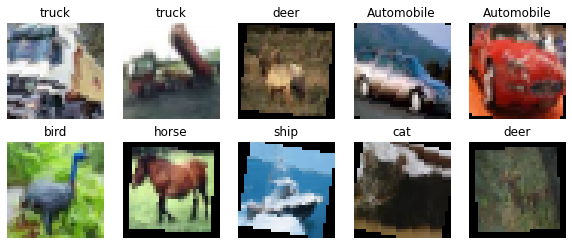

In [8]:
# Rotate and Resize
affine = transforms.RandomAffine([-15, 15], scale=(0.8, 1.2)) 
# Errase
erasing = transforms.RandomErasing(p=0.5)
normalize = transforms.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0))  # Mean is 0, standard deviation is 1
to_tensor = transforms.ToTensor()

train_data = CIFAR10('./data', 
                              train = True,  
                              download=True,  
                              transform = transforms.Compose([affine, to_tensor, normalize]),
                              # transform = transforms.Compose([to_tensor, erasing,normalize]),
                              # transform = transforms.Compose([affine, to_tensor, erasing, normalize]),
                              )
train_loader = DataLoader(train_data,batch_size=BATCH_SIZE)
imshow(train_loader)

Files already downloaded and verified
Files already downloaded and verified


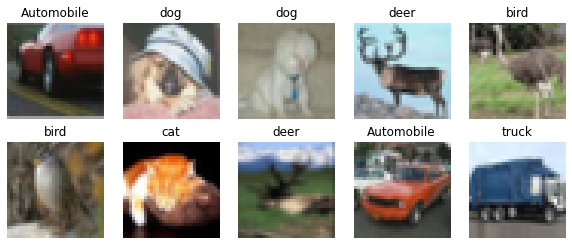

In [60]:
# Auto Augment
autoAug = transforms.AutoAugment(policy=transforms.AutoAugmentPolicy.CIFAR10)
normalize = transforms.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0))  # Mean is 0, standard deviation is 1
to_tensor = transforms.ToTensor()

transform_train = transforms.Compose([to_tensor, normalize])
# transform_train = transforms.Compose([autoAug, to_tensor, normalize])
transform_test = transforms.Compose([to_tensor, normalize])

cifar10_date = CIFAR10("./data", train=True, download=True, transform=transform_train)
cifar10_test = CIFAR10("./data", train=False, download=True, transform=transform_test)

data_len = len(cifar10_date)
train_len = int(data_len * TRAIN_RATIO)
cifar10_train = Subset(cifar10_date, [i for i in range(0, train_len)])
cifar10_val = Subset(cifar10_date, [i for i in range(train_len, data_len)])

# DataLoader settings
train_loader = DataLoader(cifar10_train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(cifar10_val, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(cifar10_test, batch_size=len(cifar10_test), shuffle=False)

imshow(train_loader)

## Model Building
In Deep Learning, a Convolutional Neural Network(CNN) is a class of deep neural networks, most commonly applied to analyzing visual imagery. 

CNN are state of the art models for Image Classification, Segmentation, Object Detection and many other image processing tasks. 

In order to improve the prediction accuracy, even now, research continues on new architectures based on CNN.
By mimicking or using some of them, our models can be improved in accuracy.

### Simple CNN
This is a simple architecture for understanding CNNs introduced in the Appendix.

In [10]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)  # Convolutional layer: (number of input channels, number of filters, filter size)
        self.pool = nn.MaxPool2d(2, 2)  # Pooling layer: (area size, stride)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 256)  # Fully Connected layer
        self.dropout = nn.Dropout(p=0.5)  # Dropout
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


### LeNet
[LeNet](http://d2l.ai/chapter_convolutional-neural-networks/lenet.html) is the first convolutional network invented in 1998.

Its structure is characterized by a set of convolutional layers and pooling layers repeated twice. Although the layers are shallower and simpler than those developed in recent years, it can achieve an accuracy of over 99% for [MNIST handwritten character images](https://www.milindsoorya.com/blog/handwritten-digits-classification) .

In [11]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) 
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.dropout_1 = nn.Dropout(0.5) 
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.dropout_2 = nn.Dropout(0.5) 
        self.fc2 = nn.Linear(120, 84)
        self.dropout_3 = nn.Dropout(0.5) 
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) 
        x = self.dropout_1(x) 
        x = F.relu(self.fc1(x))
        x = self.dropout_2(x) 
        x = F.relu(self.fc2(x))
        x = self.dropout_3(x) 
        x = self.fc3(x)
        return x

### ResNet
[Residual Network (ResNet)](https://viblo.asia/p/gioi-thieu-mang-resnet-vyDZOa7R5wj) archtecture is one of the popular and most successful deep learning models.

However, it is difficult to assemble this complex architecture by ourselves. 

[torchvision](https://pytorch.org/vision/stable/models.html) has a large number of pre-trained models that can be used to create a highly accurate architecture with a small amount of code.

In [ ]:
model_ft = models.resnet34(pretrained=True)
print(model_ft)

In [ ]:
# # simple CNN
# net = Net()

# LeNet
# net = LeNet()

# ResNet
net = models.resnet34(pretrained=True)
net.fc = nn.Linear(net.fc.in_features, 10)

net = net.to(DEVICE)
print(net)

## Learning
Train the model.  
Set the cross-entropy error as the [loss function](https://www.datarobot.com/blog/introduction-to-loss-functions/#:~:text=Further%20reading-,What's%20a%20loss%20function%3F,ll%20output%20a%20lower%20number.) and Adam as the [optimization algorithm](https://d2l.ai/chapter_optimization/index.html). 

In [ ]:
# Cross Entropy
loss_fnc = nn.CrossEntropyLoss()

# Optimization Algorithm
optimizer = optim.Adam(net.parameters())

record_loss_train = []
record_loss_val = []
record_acc_train = []
record_acc_val = []

# Leaning
for i in range(EPOCHS): 
    # Train
    net.train()
    loss_train = 0.0
    acc_train = 0.0

    label_list_train = []
    pred_list_train = []

    for j, (data, label) in enumerate(train_loader):  # Mini Batch
        data, label = data.to(DEVICE), label.to(DEVICE)
        optimizer.zero_grad()
        output = net(data)
        loss = loss_fnc(output, label)
        loss_train += loss.item()
        label_list_train += label.cpu().numpy().tolist()
        pred_list_train += torch.argmax(output,axis = 1).cpu().numpy().tolist()
        loss.backward()
        optimizer.step()

    loss_train /= j+1
    record_loss_train.append(loss_train)
    acc_train = accuracy_score(label_list_train, pred_list_train)
    record_acc_train.append(acc_train)

    # evalation 
    net.eval()  
    loss_val = 0.0
    acc_val = 0.0
    
    label_list_val = []
    pred_list_val = []

    with torch.no_grad():
      for j, (data_val, label_val) in enumerate(val_loader):
        data_val, label_val = data_val.to(DEVICE), label_val.to(DEVICE)
        output_val = net(data_val)
        loss = loss_fnc(output_val, label_val)
        loss_val += loss.item()
        label_list_val += label_val.cpu().numpy().tolist()
        pred_list_val += torch.argmax(output_val,axis = 1).cpu().numpy().tolist()

    loss_val /= j+1
    record_loss_val.append(loss_val)
    acc_val = accuracy_score(label_list_val, pred_list_val)
    record_acc_val.append(acc_val)

    if i%1 == 0:
        print ("[Epoch:", i,"]")
        print(" Loss_Train:", loss_train, "Loss_Test:", loss_val)
        print(" Acc_Train:", acc_train, "Acc_Test:", acc_val)

## Accuracy Assessment 
Using the model we created, try to evaluate its accuracy from various perspectives.

### Visualization of training progress
Displays graphs of training progress in training and test data.

[Refarence](https://matplotlib.org/) 

In [ ]:
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot(1, 2, 1)
ax.plot(range(len(record_loss_train)), record_loss_train, label="Train")
ax.plot(range(len(record_loss_val)), record_loss_val, label="Validation")

ax.set_xlabel("Epochs")
ax.set_ylabel("Error")

ax.legend()

ax = fig.add_subplot(1, 2, 2)

ax.plot(range(len(record_acc_train)), record_acc_train, label="Train")
ax.plot(range(len(record_acc_val)), record_acc_val, label="Validation")

ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")

ax.legend()

plt.show()

### Accuracy to test data
To understand the performance of the model, we measure the percentage of correct answers using test data.

In [ ]:
label_list = []
pred_list = []
for data, label in test_loader:
  data = data.to(DEVICE)
  label = label.numpy().tolist()
  pred = torch.argmax(net(data),axis = 1).cpu().numpy().tolist()
  label_list += label
  pred_list += pred

print(accuracy_score(label_list, pred_list))

### Confusion matrix
Confusion matrix can also be used to visualize the strengths and weaknesses of the model.

In [ ]:
cm = confusion_matrix(label_list,pred_list)

plt.rcParams["figure.figsize"] = (12, 10)
glaph = sns.heatmap(cm)
glaph.set( xlabel = "predict", ylabel = "label",xticklabels=labels, yticklabels=labels)

In [ ]:
plt.bar([x for x in range(10)], cm[3], width=0.5, linewidth=2, tick_label=labels)
plt.show()